# Trabalho Prático 1 de Ciência de Dados

## Download e leitura

#### Download dos dados

In [69]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv

--2025-02-11 20:54:50--  https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg
Resolving docs.google.com (docs.google.com)... 2800:3f0:4004:804::200e, 142.251.133.174
Connecting to docs.google.com (docs.google.com)|2800:3f0:4004:804::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download [following]
--2025-02-11 20:54:51--  https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2800:3f0:4004:806::2001, 142.251.135.97
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2800:3f0:4004:806::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11380332 (11M) [application/octet-stream]
Saving to: ‘filmes.csv’

filmes.csv          100%[===================>]  10,85M  4,76MB/s 

#### Leitura dos dados

Função para tranformar os gêneros dos filmes em listas de gêneros.

In [70]:
def tranform_genres(row):
    g = row.genres
    
    generos = g.split(",")
    return generos

In [71]:
import pandas as pd

filmes_df = pd.read_csv("filmes.csv")
filmes_df["genres"] = filmes_df.apply(tranform_genres, axis = 1)

filmes_df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names
0,[Family],7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston']
1,[Romance],6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch']
2,[Romance],6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker']
3,"[Romance, Family]",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer']
4,"[Crime, Action]",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann']


## Pré-processamento dos dados

In [72]:
import nltk
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /home/miguel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [73]:
from nltk import sent_tokenize, word_tokenize

#### Extrair sinopse do dataframe

In [74]:
sinopses = filmes_df.sinopse
sinopses.head()

0    When two kids find and play a magical board ga...
1    John and Max resolve to save their beloved bai...
2    Based on Terry McMillan's novel, this film fol...
3    George Banks must deal not only with his daugh...
4    A group of high-end professional thieves start...
Name: sinopse, dtype: object

In [75]:
sinopses.shape

(30358,)

#### Convertendo os tokens

In [76]:
!pip install unidecode

In [77]:
import string
import unidecode

Convertendo todos os tokens para letras minúsculas

In [78]:
def tokens_low(tokens):
  return [w.lower() for w in tokens]

Removendo os símbolos de pontuação

In [79]:
table = str.maketrans('', '', string.punctuation)

In [80]:
def tokens_pontuacao(tokens):
  return [w.translate(table) for w in tokens]

Convertendo carcteres especiais

In [81]:
def tokens_char_especical(tokens):
  return [unidecode.unidecode(w).lower() for w in tokens]

#### Filtrando apenas palavras

Extraindo apenas as palavras da lista de tokens

In [82]:
def tokens_apenas_words(tokens):
  return [word for word in tokens if word.isalpha()]

Removendo stop words

In [83]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/miguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
stop_words = set(stopwords.words('english'))

In [85]:
def tokens_stop_words(tokens):
  return [word for word in tokens if not word in stop_words]

#### Stemming

In [86]:
from nltk.stem.porter import PorterStemmer

In [87]:
porter = PorterStemmer()

In [88]:
def tokens_stemming(tokens):
  return [porter.stem(word) for word in tokens]

#### Tokenizer Personalizado

In [89]:
def tokenizer_personalizado(texto):
  tokens = word_tokenize(texto)

  tokens = tokens_low(tokens)
  tokens = tokens_pontuacao(tokens)
  tokens = tokens_char_especical(tokens)
  tokens = tokens_apenas_words(tokens)
  tokens = tokens_stop_words(tokens)
  tokens = tokens_stemming(tokens)

  return tokens

## Construção da matriz de TF-IDF

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
# Cada linha do array é uma sinopse
D = [sin for sin in filmes_df.sinopse]

### Usando Tokenizer Personalizado

In [92]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_personalizado)
X = vectorizer.fit_transform(D)

/home/miguel/anaconda3/envs/data-science/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [93]:
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
vectorizer.get_feature_names_out()

array(['aa', 'aadhavan', 'aadhi', ..., 'zylberberg', 'zylberstein',
       'zyto'], dtype=object)

In [95]:
df = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
df

,aa,aadhavan,aadhi,aakansha,aakash,aaliya,aalst,aaltonen,aamir,aang,...,zuzu,zvezda,zweig,zydruna,zyga,zygon,zyl,zylberberg,zylberstein,zyto
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Usando o Padrão da Bibilioteca

In [96]:
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(D)

In [97]:
# X.todense()

In [98]:
# vectorizer.get_feature_names_out()

In [99]:
# df = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
# df

## Redução de dimensionalidade

In [100]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

In [101]:
X.shape

(30358, 33435)

In [103]:
svd = TruncatedSVD(n_components=4000)
X_REDUCED = svd.fit_transform(X)

In [104]:
y = filmes_df.genres
y

0                 [Family]
1                [Romance]
2                [Romance]
3        [Romance, Family]
4          [Crime, Action]
               ...        
30353          [Biography]
30354          [Biography]
30355      [Crime, Horror]
30356            [Romance]
30357             [Action]
Name: genres, Length: 30358, dtype: object

In [105]:
genre_types = []

for g_array in y:
    for g in g_array:
        if g not in genre_types:
            genre_types.append(g)

In [106]:
df_reduced = pd.DataFrame(X_REDUCED)
df_reduced

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.136516,-0.025150,0.009167,-0.012127,0.019542,0.019704,-0.111521,-0.004197,-0.068128,-0.038404,...,0.002847,-0.001660,-0.001538,0.000216,-0.000898,0.000826,-0.001625,-0.000218,0.002581,-0.001976
1,0.064629,-0.026654,-0.018935,-0.013126,-0.029011,-0.042360,0.064542,0.023304,-0.048375,-0.019331,...,0.000203,0.008190,-0.008006,0.000884,0.003315,0.000012,-0.001654,0.002251,0.007749,0.006974
2,0.075667,0.006529,-0.053290,0.012761,0.042374,0.020600,-0.014630,0.037913,0.076045,-0.049392,...,0.005596,0.001615,0.005146,-0.002091,-0.002114,-0.000200,-0.005698,0.000484,-0.002708,0.005146
3,0.089127,-0.036099,0.016204,0.008610,0.003377,-0.089704,-0.031214,0.001357,-0.036406,0.067716,...,0.005259,-0.003252,0.002167,-0.003625,-0.004289,0.000693,0.000123,-0.000003,0.001208,0.001916
4,0.048744,-0.032306,-0.015694,-0.007416,0.000457,0.011696,-0.001503,0.006161,-0.016969,-0.029328,...,-0.001787,-0.002450,0.007138,-0.006203,-0.005076,-0.001914,-0.000853,0.007460,-0.013819,-0.003396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30353,0.057663,0.013130,-0.020834,-0.001594,0.004394,-0.011965,0.020135,0.019724,0.009468,-0.022469,...,0.005918,0.005751,-0.017451,-0.019118,0.004579,-0.000103,-0.011098,-0.023093,-0.005862,-0.003750
30354,0.026405,0.004523,-0.024850,-0.002702,0.014800,-0.015241,0.019852,0.001290,0.009411,-0.010083,...,-0.000760,-0.002404,-0.002356,-0.003534,0.003740,-0.002463,-0.001277,-0.002321,0.001368,-0.000519
30355,0.037829,-0.031345,0.003902,-0.017844,0.036836,0.002433,0.003638,-0.025769,-0.016818,0.014869,...,-0.002222,-0.003468,-0.000144,0.001717,0.001877,0.002597,0.000479,0.002577,0.002954,0.001734
30356,0.155643,0.070353,0.108121,-0.080275,-0.054899,-0.009960,-0.080468,-0.066273,-0.008991,0.008182,...,-0.004157,-0.009493,0.011717,0.005319,0.000414,-0.001227,-0.010467,0.006875,-0.001126,0.005743


## Agrupamento

#### K-means

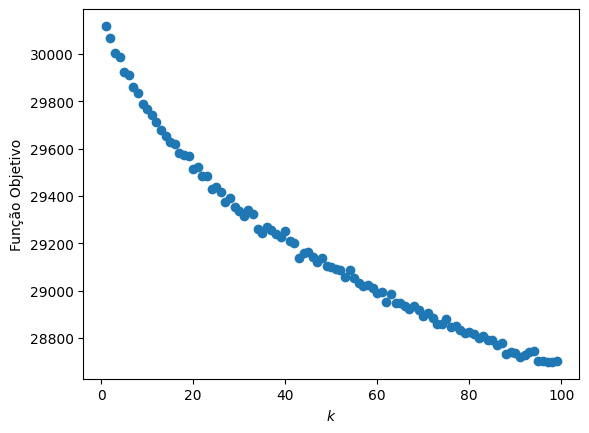

In [108]:
from sklearn.cluster import KMeans

inertia = []
for i in range(1, 100):
    km = KMeans(n_clusters = i)
    km.fit(X)
    inertia.append(km.inertia_)

plt.scatter(range(1, 100), inertia)
_ = plt.ylabel("Função Objetivo")
_ = plt.xlabel(r"$k$")

In [109]:
kmeans = KMeans(n_clusters=90)
kmeans.fit(X_REDUCED)
y_kmeans = kmeans.predict(X_REDUCED)

In [110]:
kmeans_prediction_df = filmes_df
kmeans_prediction_df["prediction"] = y_kmeans
kmeans_prediction_df

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names,prediction
0,[Family],7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston'],42
1,[Romance],6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch'],72
2,[Romance],6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker'],19
3,"[Romance, Family]",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer'],58
4,"[Crime, Action]",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann'],72
...,...,...,...,...,...,...,...,...,...,...
30353,[Biography],7.2,1623,"""I'll look at you, but not at the camera. It c...",Jane B. for Agnes V.,1988,99,['Jean-Pierre Léaud' 'Philippe Léotard' 'Phili...,['Agnès Varda'],72
30354,[Biography],6.3,55,A musical biography of the great Russian class...,Rimskiy-Korsakov,1953,88,['Grigori Belov' 'Nikolay Cherkasov' 'Aleksand...,['Gennadiy Kazanskiy' 'Grigoriy Roshal'],72
30355,"[Crime, Horror]",5.3,391,An evil genius uses poison gas to avenge himse...,The Carpet of Horror,1962,85,['Joachim Fuchsberger' 'Antonio Casas' 'Fernan...,['Harald Reinl'],56
30356,[Romance],7.5,2127,A young man narrates his past on how his fathe...,Santhosh Subramaniyam,2008,177,['Jayam Ravi' 'Prakash Raj' 'Sayaji Shinde' 'S...,['Mohan Raja'],34


In [111]:
group1 = kmeans_prediction_df[kmeans_prediction_df["prediction"] == 1]
group1

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names,prediction
38,[Romance],6.5,7571,"An uptight and conservative woman, working on ...",When Night Is Falling,1995,94,['Henry Czerny' 'David Fox' 'Don McKellar' 'Jo...,['Patricia Rozema'],1
62,"[Crime, Action]",6.3,45833,"An unimpressive, everyday man is forced into a...",Nick of Time,1995,90,['Johnny Depp' 'Christopher Walken' 'Charles S...,['John Badham'],1
67,[Crime],8.1,204853,24 hours in the lives of three young men in th...,La haine,1995,98,['Vincent Cassel' 'Hubert Koundé' 'Saïd Taghma...,['Mathieu Kassovitz'],1
83,[Romance],5.6,32059,A successful executive and womanizer finds his...,Boomerang,1992,117,['Eddie Murphy' 'David Alan Grier' 'Martin Law...,['Reginald Hudlin'],1
87,[Romance],5.7,916,A whimsical saga of a young man whose two life...,Pie in the Sky,1995,95,['Josh Charles' 'John Goodman' 'Peter Riegert'...,['Bryan Gordon'],1
...,...,...,...,...,...,...,...,...,...,...
30301,[Horror],5.3,1404,"Francesca, a young pediatrician, and her husba...",The Haunting,2009,94,['Francisco Boira' 'Héctor Colomé' 'Francisco ...,['Elio Quiroga'],1
30305,[Horror],4.2,210,A curse haunts Owl Lake. Legend has it that th...,Lady of the Lake,1998,82,['Erik Rutherford' 'Emidio Michetti' 'Christop...,['Maurice Devereaux'],1
30314,[Horror],4.9,2400,A direct sequel to 2011's The Woman.,Darlin',2019,100,['Cooper Andrews' 'Bryan Batt'],['Pollyanna McIntosh'],1
30332,[Romance],5.9,25466,"In a small town on Christmas Eve, a snowstorm ...",Let It Snow,2019,92,['Shameik Moore' 'Mitchell Hope' 'Matthew Nosz...,['Luke Snellin'],1


#### Criando estatísticas para os gêneros em cada grupo

In [ ]:
_group1_statistics = {}
_group1_genres = group1.genres

for g in genre_types:
    _group1_statistics[g] = 0

for g_array in _group1_genres:
    for g in g_array:
        _group1_statistics[g] += 1

Text(0, 0.5, 'Porcentagem do gênero no grupo')

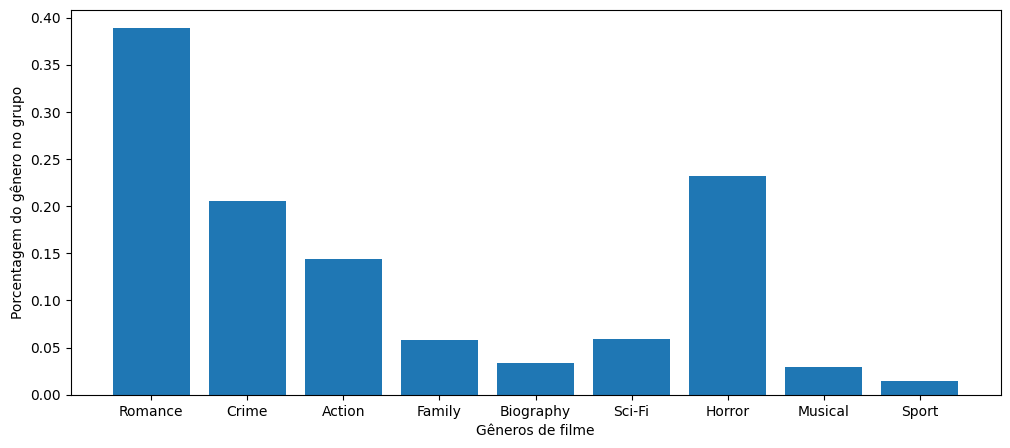

In [133]:
plt.figure(figsize=(12, 5))
plt.bar(_group1_statistics.keys(), [v/len(_group1_genres) for v in _group1_statistics.values()])
plt.xlabel("Gêneros de filme")
plt.ylabel("Porcentagem do gênero no grupo")

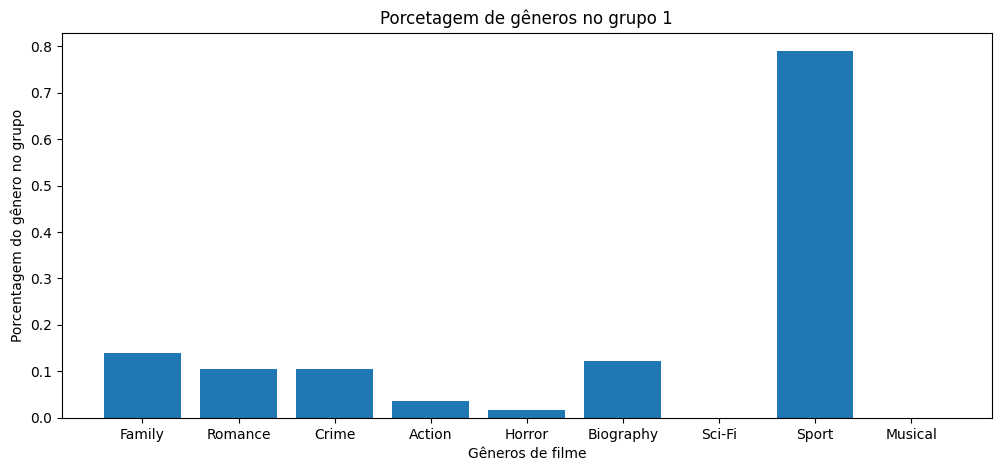

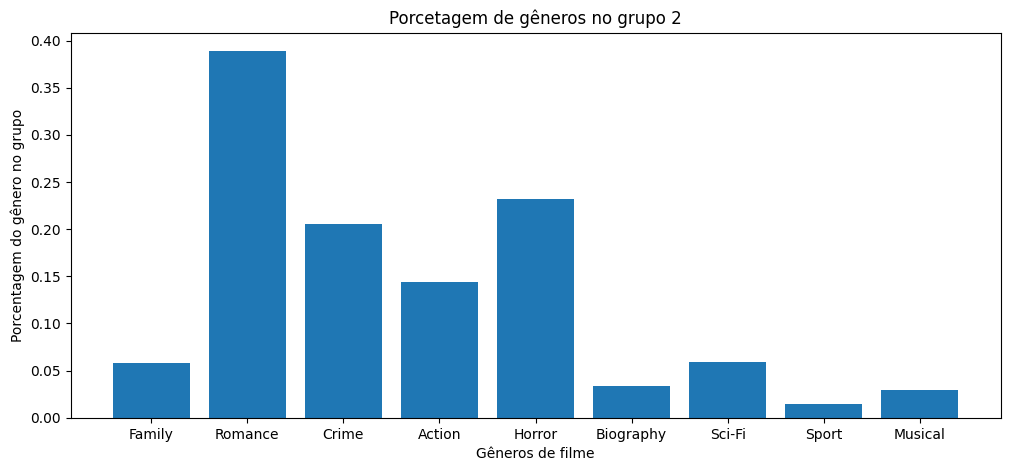

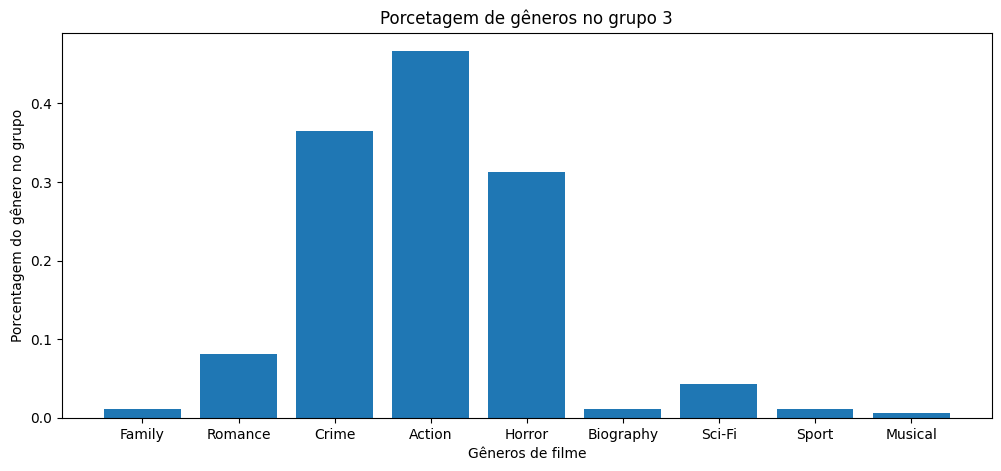

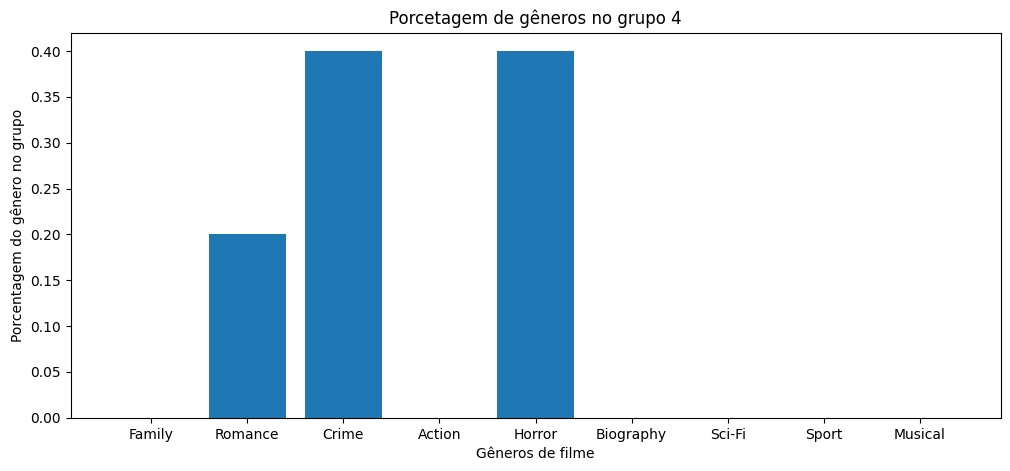

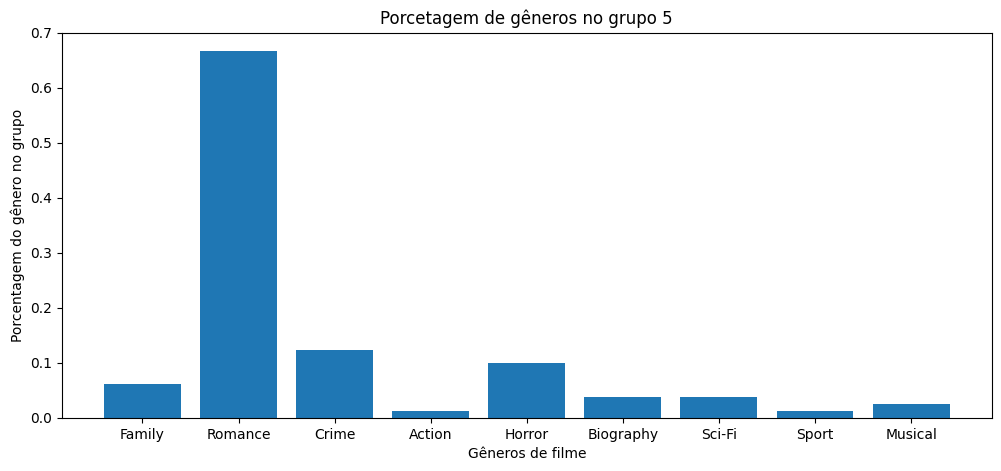

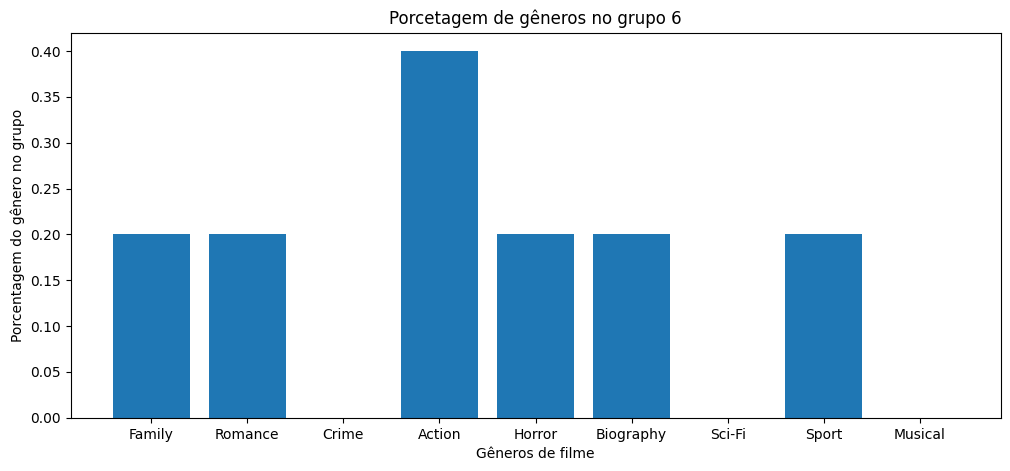

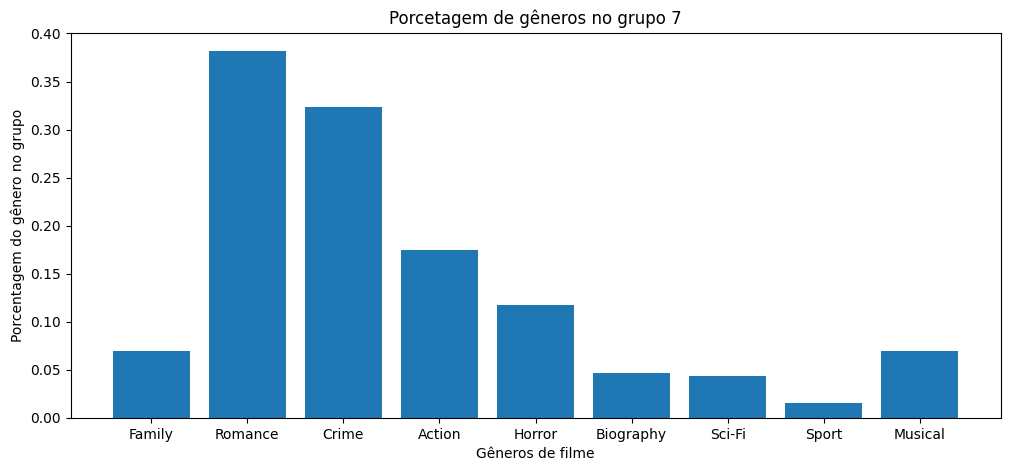

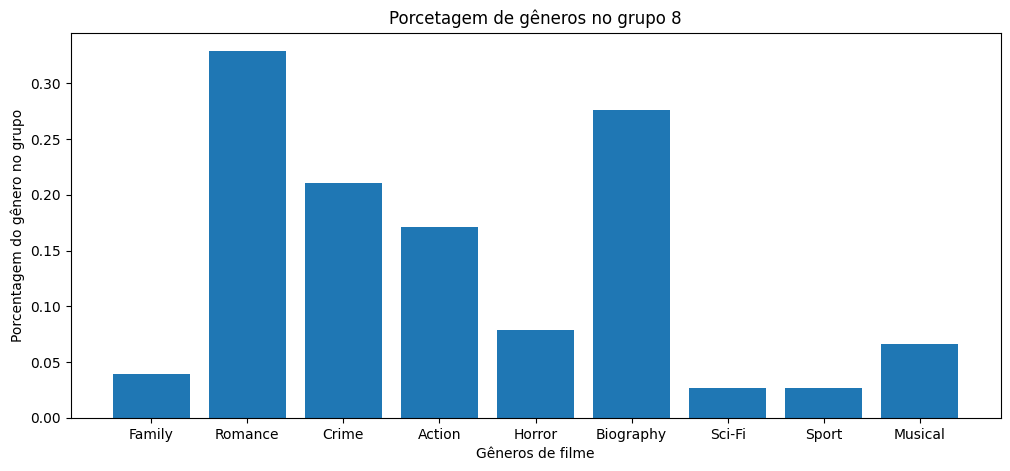

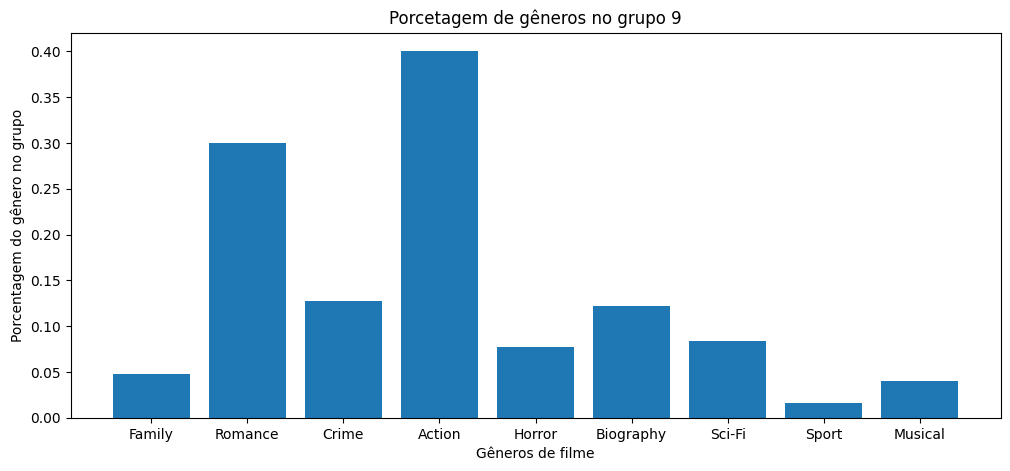

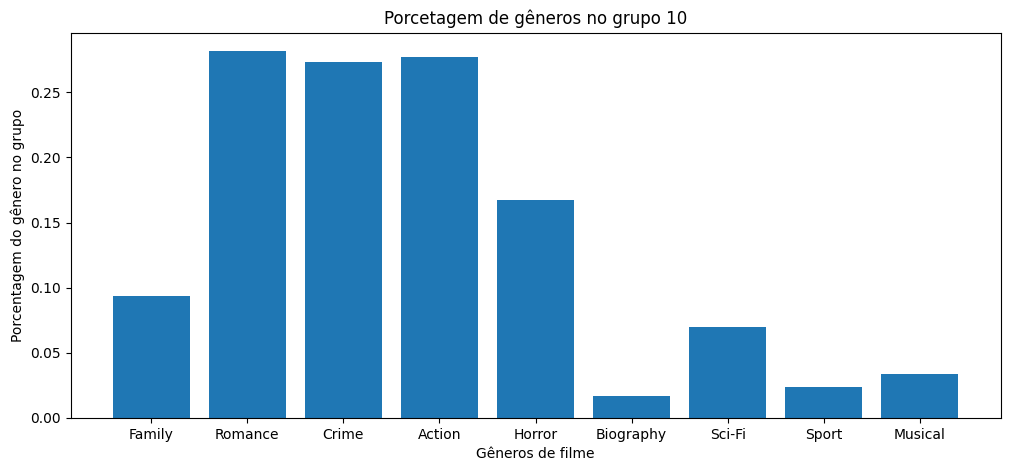

In [136]:
for i in range(10):
    curr_group = kmeans_prediction_df[kmeans_prediction_df["prediction"] == i]
    
    _group_statistics = {}
    _group_genres = curr_group.genres

    for g in genre_types:
        _group_statistics[g] = 0

    for g_array in _group_genres:
        for g in g_array:
            _group_statistics[g] += 1
    
    plt.figure(figsize=(12, 5))
    plt.bar(_group_statistics.keys(), [v/len(_group_genres) for v in _group_statistics.values()])
    plt.xlabel("Gêneros de filme")
    plt.ylabel("Porcentagem do gênero no grupo")
    plt.title(f"Porcetagem de gêneros no grupo {i+1}")